<a href="https://colab.research.google.com/github/emanbuc/ultrasonic-vision/blob/main/notebooks/create_training_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparazione dataset per training classificatore

In [40]:
# Univariate Histograms
import matplotlib.pyplot as plt
import pandas
url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/dataset/20210102_alldata_outlier_removed.csv"

names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007','ObjectClass']
data = pandas.read_csv(url, usecols=names)
print(data)

     HCSR04_001  HCSR04_002  HCSR04_003  ...  HCSR04_006  HCSR04_007  ObjectClass
0         55.59       16.09       54.78  ...       57.48       96.38  BALL_CENTER
1         56.40       16.06       55.29  ...       57.42      109.68  BALL_CENTER
2         56.32       16.04       54.86  ...       58.30      116.21  BALL_CENTER
3         55.08       15.96       54.87  ...       58.28       78.56  BALL_CENTER
4         55.11       15.96       55.22  ...       57.86      111.51  BALL_CENTER
..          ...         ...         ...  ...         ...         ...          ...
302       53.43       55.59       55.07  ...       51.77      109.41    WALL_BALL
303       53.40       55.57       55.13  ...       52.60      107.89    WALL_BALL
304       53.83       55.60       55.14  ...       51.70      111.39    WALL_BALL
305       53.40       55.97       55.08  ...       51.74      109.09    WALL_BALL
306       53.41       55.63       54.76  ...       52.51      108.74    WALL_BALL

[307 rows x 8 c

In [41]:
df_EMPTY=data[data['ObjectClass']=='EMPTY_SEVEN']
distanceColumns= ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007']
categorialColumns =['ObjectClass']

## Analisi delle features
I range dell feaute sono molto diversi a causa degli errori di stima. Per una analisi visiva è necessario prima rimuove gli outliers
Le sistanze dipendono sia dalla posiizone dell'oggetto che dal tipo di oggetto. 

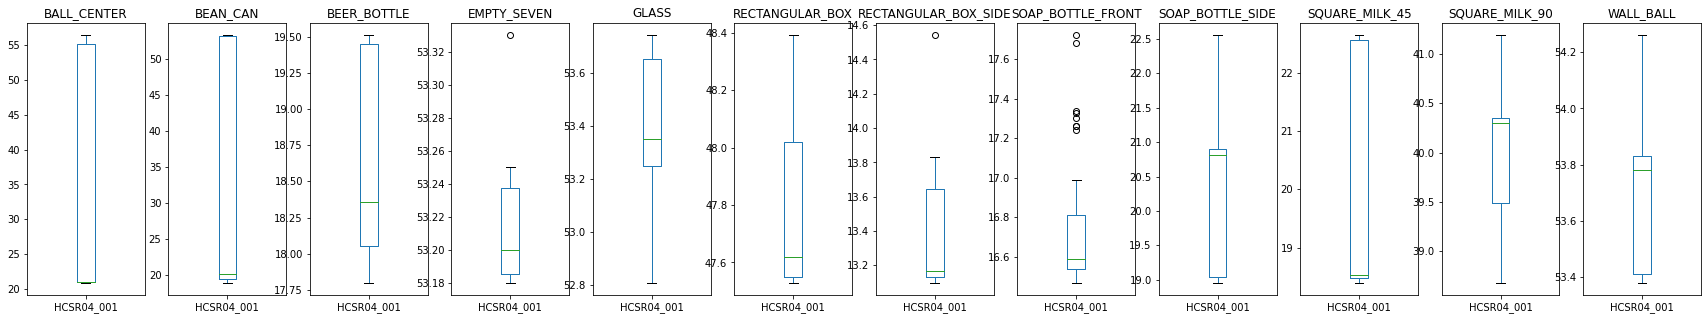

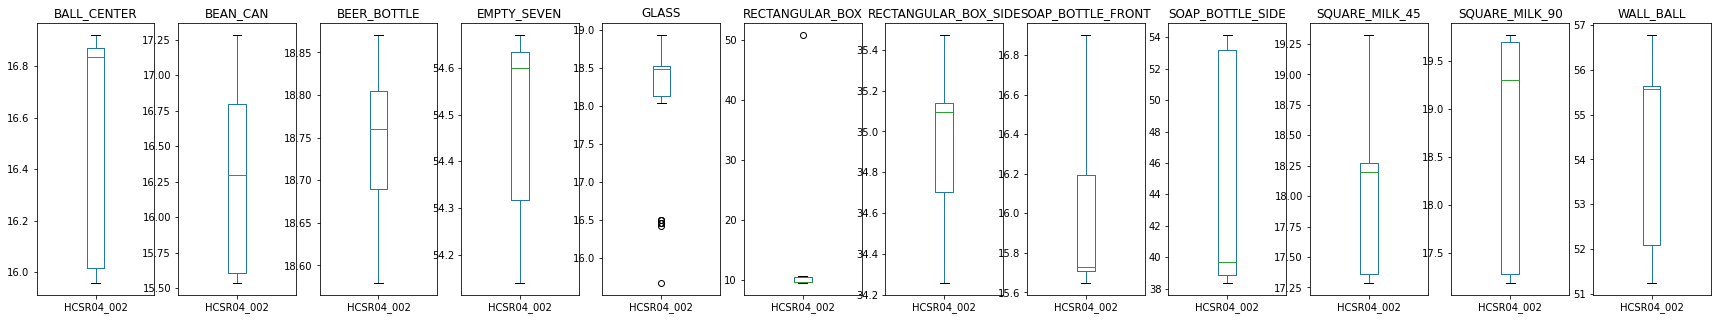

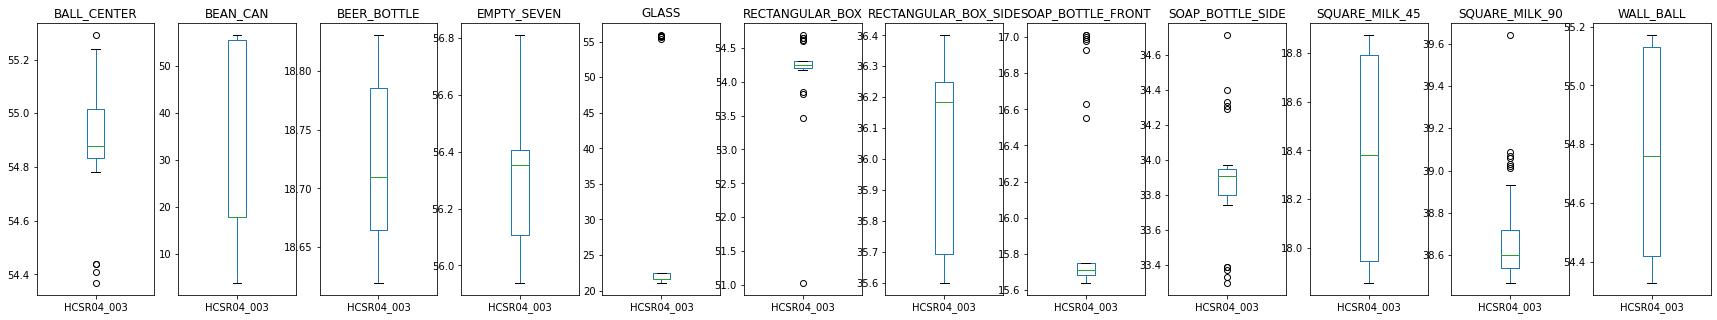

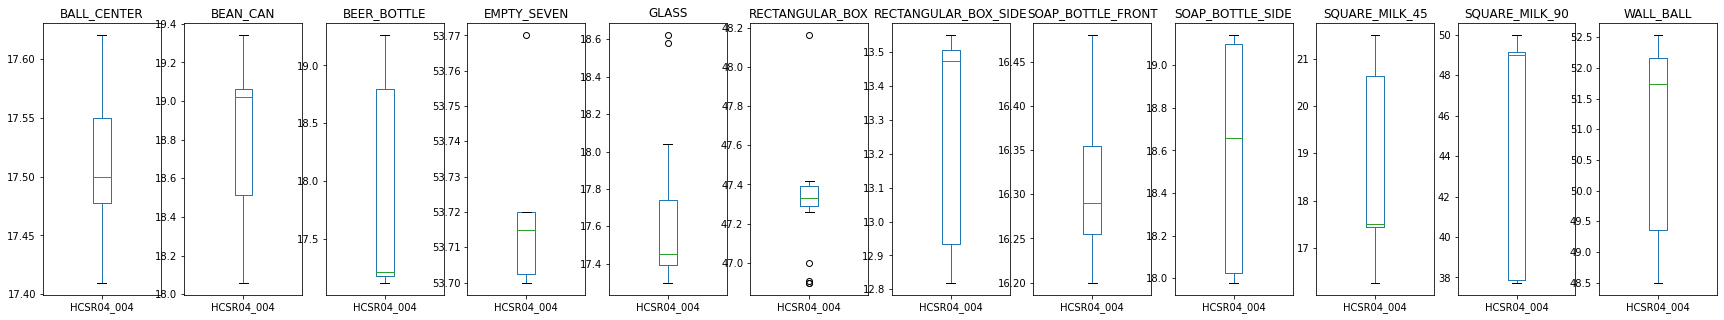

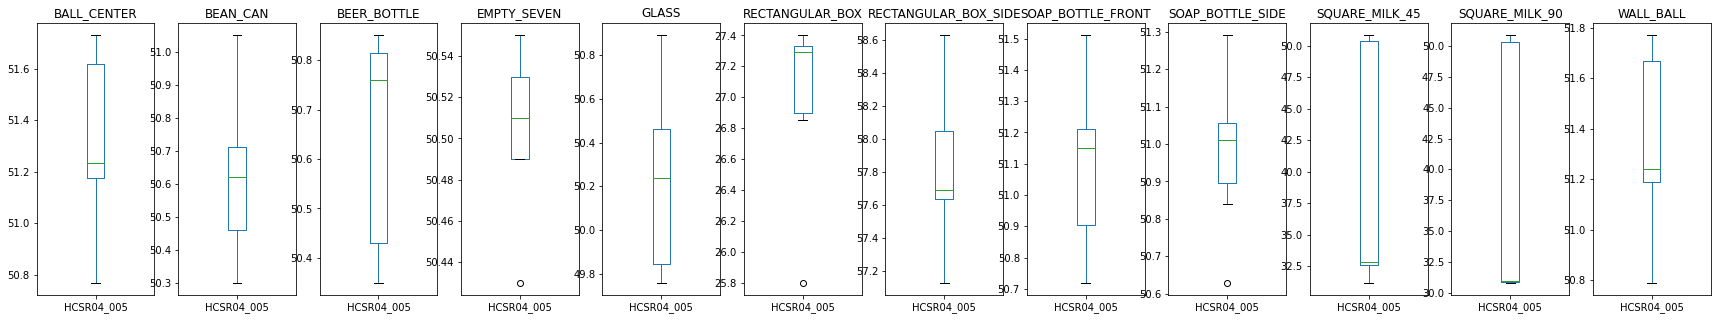

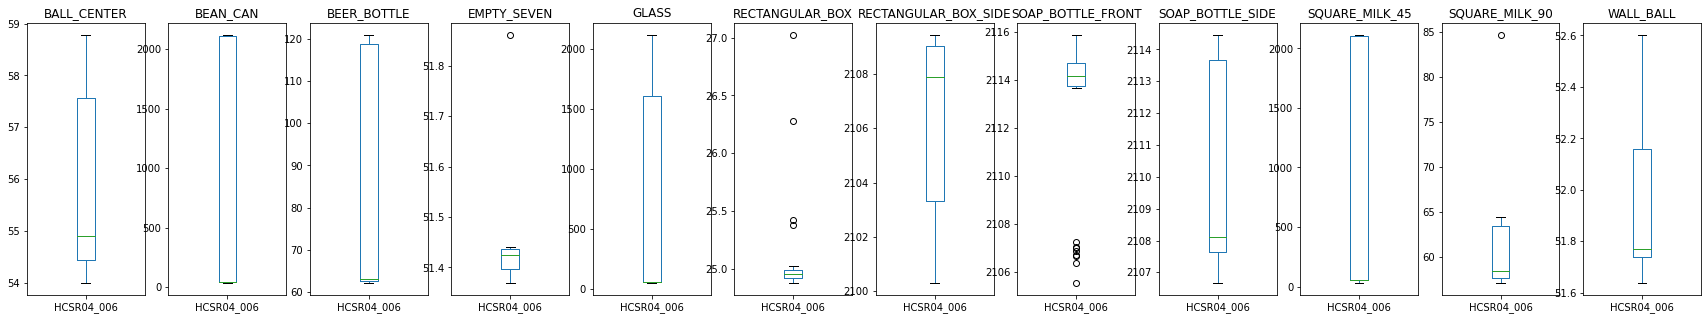

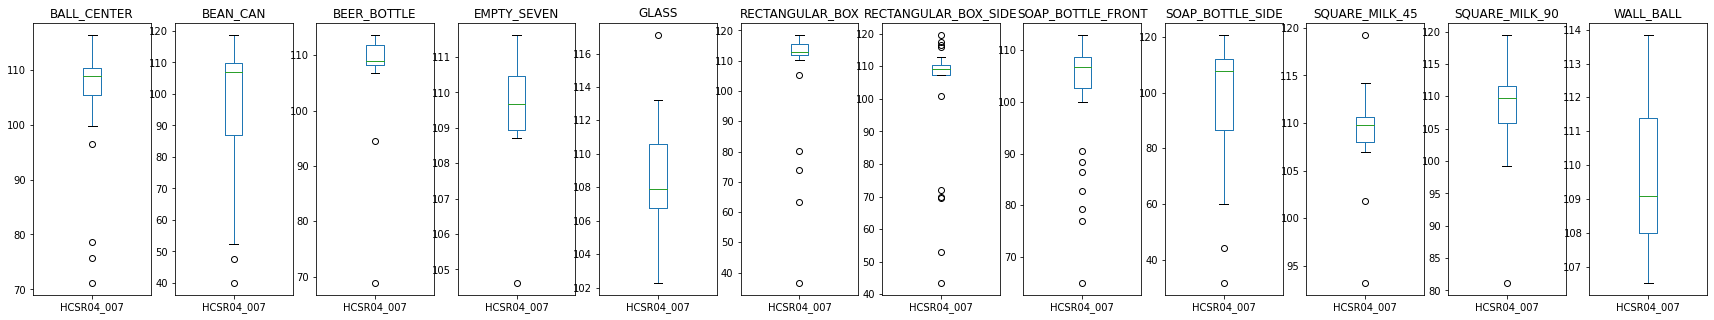

In [42]:
groupedByClass = data.groupby(['ObjectClass'])
for featureName in distanceColumns:
  fig, axes = plt.subplots(ncols=groupedByClass.ngroups, figsize=(30, 5))
  index=0  
  for name, group in groupedByClass:
    group[featureName].plot(kind='box', ax=axes[index], title=name)
    index=index+1


## New Features

Le distanze dipendono fortemente dalla posizione esatta dell'oggetto all'interno dell'area di misura. I modelli addestrati hanno problemi di overfitting e funzionano bene solo se gli oggetti vengono posizionati in maniera precisa. Aggiungo nuove feature derivate per cercare di ottenere una classificazione più robusta rispetto al posizionamento degli oggetti.

### Oggetto Rilevato

Boolean: True se il sensore rileva un bersaglio (), False se non viene rilevato un oggetto (lettura compatibile con EMPTY_SEVEN)

In [43]:
for colName in distanceColumns:
  maxValue= max(df_EMPTY[colName])
  minValue= min(df_EMPTY[colName])
  print(colName+ "min: "+str(minValue)+"max: "+str(maxValue))
  data[colName+'_empty']= (data[colName]<= maxValue) & (data[colName] >=minValue)
  categorialColumns.append(colName+'_empty')

data

HCSR04_001min: 53.18max: 53.33
HCSR04_002min: 54.14max: 54.67
HCSR04_003min: 55.94max: 56.81
HCSR04_004min: 53.7max: 53.77
HCSR04_005min: 50.43max: 50.55
HCSR04_006min: 51.37max: 51.86
HCSR04_007min: 104.63max: 111.61


,HCSR04_001,HCSR04_002,HCSR04_003,HCSR04_004,HCSR04_005,HCSR04_006,HCSR04_007,ObjectClass,HCSR04_001_empty,HCSR04_002_empty,HCSR04_003_empty,HCSR04_004_empty,HCSR04_005_empty,HCSR04_006_empty,HCSR04_007_empty
0,55.59,16.09,54.78,17.55,51.73,57.48,96.38,BALL_CENTER,False,False,False,False,False,False,False
1,56.40,16.06,55.29,17.48,51.27,57.42,109.68,BALL_CENTER,False,False,False,False,False,False,True
2,56.32,16.04,54.86,17.55,51.26,58.30,116.21,BALL_CENTER,False,False,False,False,False,False,False
3,55.08,15.96,54.87,17.62,51.24,58.28,78.56,BALL_CENTER,False,False,False,False,False,False,False
4,55.11,15.96,55.22,17.57,51.71,57.86,111.51,BALL_CENTER,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,53.43,55.59,55.07,52.16,51.25,51.77,109.41,WALL_BALL,False,False,False,False,False,True,True
303,53.40,55.57,55.13,52.10,51.71,52.60,107.89,WALL_BALL,False,False,False,False,False,False,True
304,53.83,55.60,55.14,52.53,51.29,51.70,111.39,WALL_BALL,False,False,False,False,False,True,True
305,53.40,55.97,55.08,52.22,51.17,51.74,109.09,WALL_BALL,False,False,False,False,False,True,True


## Binning

In [44]:
import numpy as np

binLabels=["NEAR","CENTER","FAR"]
binCuts=[-np.inf,20,40,np.inf]

for colName in distanceColumns:
  bins= pandas.cut(data[colName], bins=binCuts,labels=binLabels)
  data[colName+'_BIN']=bins
  categorialColumns.append(colName+'_BIN')

data[data['HCSR04_001'] < 20]
categorialColumns

['ObjectClass',
 'HCSR04_001_empty',
 'HCSR04_002_empty',
 'HCSR04_003_empty',
 'HCSR04_004_empty',
 'HCSR04_005_empty',
 'HCSR04_006_empty',
 'HCSR04_007_empty',
 'HCSR04_001_BIN',
 'HCSR04_002_BIN',
 'HCSR04_003_BIN',
 'HCSR04_004_BIN',
 'HCSR04_005_BIN',
 'HCSR04_006_BIN',
 'HCSR04_007_BIN']

## Analisi correlazione


In [45]:
# The data is categorial so I convert it with LabelEncoder to transfer to ordinal.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
for column in categorialColumns:
    data[column] = labelencoder.fit_transform(data[column])

In [46]:
dataCategoricalOnly = data.loc[:,categorialColumns]

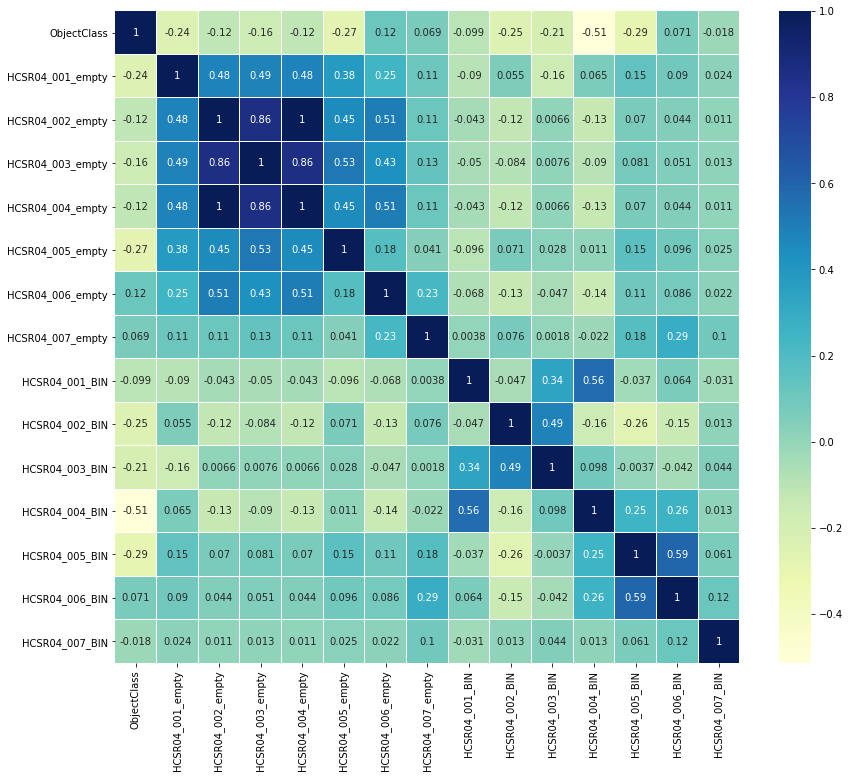

In [47]:
import seaborn as sns
plt.figure(figsize=(14,12))
sns.heatmap(dataCategoricalOnly.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

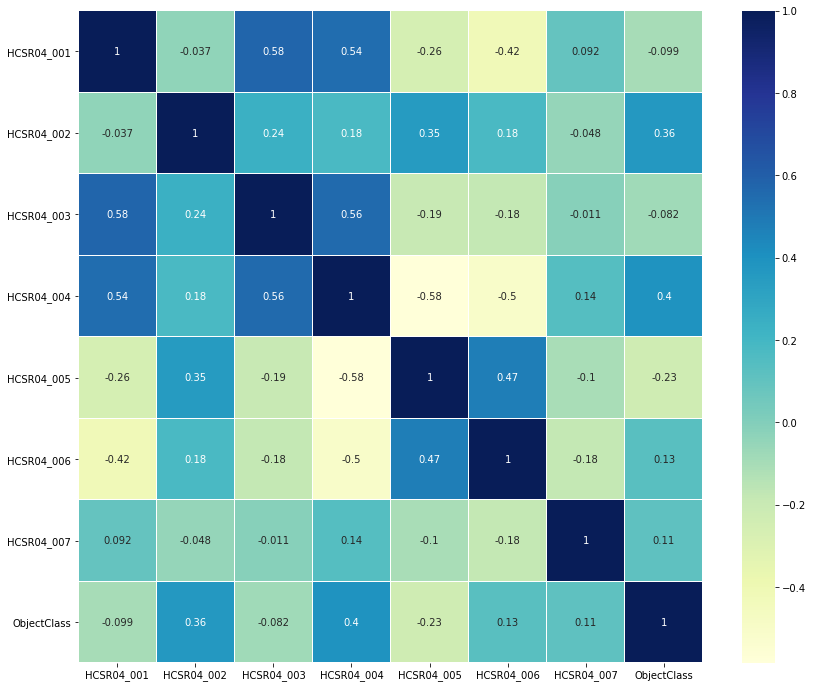

In [48]:
dataDistances = data.iloc[:,[0,1,2,3,4,5,6,7]]
import seaborn as sns
plt.figure(figsize=(14,12))
sns.heatmap(dataDistances.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);